In [1]:
# Initialize CUDA settings
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from difflib import SequenceMatcher
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
import random
import math
from tqdm.notebook import tqdm

# GPU Optimizations
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = True

# Clear CUDA cache
torch.cuda.empty_cache()
if torch.cuda.is_available():
    print(f"GPU Memory available: {torch.cuda.get_device_properties(0).total_memory/1024**2:.0f}MB")

def setup_codebert():
    """Download and cache CodeBERT model with retries"""
    print("Setting up CodeBERT model...\n")

    # Create cache directory
    cache_dir = os.path.join('codebert_cache')
    os.makedirs(cache_dir, exist_ok=True)

    try:
        print("Loading tokenizer...")
        tokenizer = RobertaTokenizer.from_pretrained(
            'microsoft/codebert-base',
            cache_dir=cache_dir,
            local_files_only=False,
            trust_remote_code=True
        )

        print("Loading model...")
        model = RobertaModel.from_pretrained(
            'microsoft/codebert-base',
            cache_dir=cache_dir,
            local_files_only=False,
            trust_remote_code=True
        )

        # Enable memory optimizations
        if torch.cuda.is_available():
            model.gradient_checkpointing_enable()

        return tokenizer, model

    except Exception as e:
        print(f"Error during setup: {str(e)}")
        raise

# Initialize model
print("Initializing CodeBERT...")
tokenizer, base_model = setup_codebert()

GPU Memory available: 15095MB
Initializing CodeBERT...
Setting up CodeBERT model...

Loading tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Loading model...


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [2]:
@dataclass
class CodeSample:
    code: str
    label: int
    cwe: str = None
    processed_code: str = None

    def preprocess(self):
        code = self.code.strip()
        code = ' '.join(code.split())
        self.processed_code = code
        return self

In [3]:
import os
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from difflib import SequenceMatcher
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
import random
import math
from tqdm.notebook import tqdm

# GPU Optimizations
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = True

def setup_codebert():
    """Download and cache CodeBERT model with retries"""
    print("Setting up CodeBERT model...\n")

    # Create cache directory in the current working directory
    cache_dir = os.path.join('codebert_cache')
    os.makedirs(cache_dir, exist_ok=True)

    try:
        print("Attempting to load tokenizer...")
        tokenizer = RobertaTokenizer.from_pretrained(
            'microsoft/codebert-base',
            cache_dir=cache_dir,
            local_files_only=False,
            from_tf=True,
            trust_remote_code=True
        )

        print("\nAttempting to load model...")
        model = RobertaModel.from_pretrained(
            'microsoft/codebert-base',
            cache_dir=cache_dir,
            local_files_only=False,
            from_tf=True,
            trust_remote_code=True
        )

        # Save model for reuse
        model_path = os.path.join(cache_dir, 'codebert_base.pt')
        if not os.path.exists(model_path):
            print("\nSaving model to cache...")
            torch.save(model.state_dict(), model_path)

        print("\nCodeBERT setup completed successfully!")
        return tokenizer, model

    except Exception as e:
        print(f"Error during setup: {str(e)}")
        raise

# Run setup
print("Initializing CodeBERT...")
tokenizer, base_model = setup_codebert()

Initializing CodeBERT...
Setting up CodeBERT model...

Attempting to load tokenizer...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]


Attempting to load model...


tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for embeddings.word_embeddings.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for embeddings.position_embeddings.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for embeddings.token_type_embeddings.weight: copying from a non-meta parameter in the checkpoint t


Saving model to cache...

CodeBERT setup completed successfully!


In [4]:
from dataclasses import dataclass
import os
import torch
import numpy as np
import random

@dataclass
class CodeSample:
    code: str
    label: int
    cwe: str = None
    processed_code: str = None

    def preprocess(self):
        code = self.code.strip()
        code = ' '.join(code.split())
        self.processed_code = code
        return self

# CUDA Initialization and Environment Setup
def setup_cuda(seed=42, enable_tf32=True):
    """
    Safe CUDA initialization with T4-specific optimizations
    """
    # Set environment variables for T4 optimization
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    os.environ['TORCH_USE_CUDA_DSA'] = '1'

    # Basic random seeds
    random.seed(seed)
    np.random.seed(seed)

    # Default to CPU
    device = torch.device('cpu')

    try:
        if torch.cuda.is_available():
            # Clear any existing CUDA memory
            torch.cuda.empty_cache()

            # Get device properties
            device = torch.device('cuda')
            props = torch.cuda.get_device_properties(device)
            print(f"\nFound CUDA device: {props.name}")
            print(f"Compute capability: {props.major}.{props.minor}")
            print(f"Memory: {props.total_memory / 1024**3:.1f} GB")

            # Basic PyTorch seed
            torch.manual_seed(seed)

            # CUDA-specific setup with error check
            try:
                torch.cuda.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)

                # T4-specific optimizations
                if enable_tf32 and torch.cuda.get_device_capability()[0] >= 7:
                    print("Enabling TF32 for better T4 performance")
                    torch.backends.cuda.matmul.allow_tf32 = True
                    torch.backends.cudnn.allow_tf32 = True

                # Use adaptive memory management
                torch.backends.cudnn.benchmark = True

                # Test CUDA operation
                test_tensor = torch.zeros(1).to(device)
                del test_tensor

                print("CUDA initialization successful")
                return device

            except RuntimeError as e:
                print(f"CUDA setup failed: {e}")
                print("Falling back to CPU")
                torch.cuda.empty_cache()
                return torch.device('cpu')
        else:
            print("No CUDA device available")
            return device

    except Exception as e:
        print(f"Unexpected error during CUDA setup: {e}")
        return device

# Initialize device
print("Initializing compute device...")
device = setup_cuda(seed=42)
print(f"Using device: {device}")

# Verify CUDA state if using GPU
if device.type == 'cuda':
    print("\nCUDA Status:")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"PyTorch CUDA: {torch.backends.cudnn.version()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(device)/1024**2:.1f} MB")

Initializing compute device...

Found CUDA device: Tesla T4
Compute capability: 7.5
Memory: 14.7 GB
Enabling TF32 for better T4 performance
CUDA initialization successful
Using device: cuda

CUDA Status:
CUDA version: 12.4
PyTorch CUDA: 90300
Current device: 0
Memory allocated: 0.0 MB


In [5]:
import os
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import roc_auc_score
from difflib import SequenceMatcher
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
import random
import math
from tqdm.notebook import tqdm

# GPU Optimizations
torch.manual_seed(42)
np.random.seed(42)

def setup_codebert(enable_checkpoint=True):
    """Download and cache CodeBERT model with memory optimizations"""
    print("Setting up CodeBERT model...\n")

    # Create cache directory in the current working directory
    cache_dir = os.path.join('codebert_cache')
    os.makedirs(cache_dir, exist_ok=True)

    try:
        print("Attempting to load tokenizer...")
        tokenizer = RobertaTokenizer.from_pretrained(
            'microsoft/codebert-base',
            cache_dir=cache_dir,
            local_files_only=False,
            from_tf=True,
            trust_remote_code=True
        )

        print("\nAttempting to load model...")
        model = RobertaModel.from_pretrained(
            'microsoft/codebert-base',
            cache_dir=cache_dir,
            local_files_only=False,
            from_tf=True,
            trust_remote_code=True
        )

        if enable_checkpoint and torch.cuda.is_available():
            print("\nEnabling gradient checkpointing for memory efficiency...")
            model.gradient_checkpointing_enable()

        # Memory optimization for T4
        if torch.cuda.is_available():
            # Use mixed precision
            print("\nEnabling automatic mixed precision...")
            model = model.half()

        # Save model for reuse
        model_path = os.path.join(cache_dir, 'codebert_base.pt')
        if not os.path.exists(model_path):
            print("\nSaving model to cache...")
            torch.save(model.state_dict(), model_path)

        print("\nCodeBERT setup completed successfully!")
        return tokenizer, model

    except Exception as e:
        print(f"Error during setup: {str(e)}")
        raise

# Run setup
print("Initializing CodeBERT...")
tokenizer, base_model = setup_codebert(enable_checkpoint=True)

class VulnDataset:
    def __init__(self, data_path: str):
        from collections import defaultdict

        print("Loading data...")
        self.df = pd.read_csv(data_path)
        print(f"Initial samples: {len(self.df)}")

        self.df = self.df[self.df['code'].notna()].copy()
        self.df = self.df[self.df['code'].str.strip() != ''].copy()
        print(f"Samples after cleaning: {len(self.df)}")

        # Define CWE classes including 'none' as a valid class
        self.cwe_classes = ["CWE121", "CWE78", "CWE190", "CWE191", "CWE122", "none"]
        self.num_classes = len(self.cwe_classes)
        self.cwe_to_idx = {cwe: idx for idx, cwe in enumerate(self.cwe_classes)}

        # Use global tokenizer
        self.tokenizer = tokenizer
        self.samples: List[CodeSample] = []
        self._prepare_samples()

    def preprocess_code(self, code: str) -> str:
        # Remove comments and convert to single line to reduce pattern matching
        import re
        code = re.sub(r'\/\*[\s\S]*?\*\/|\/\/.*', '', code)

        # Remove common includes and defines that could leak information
        lines = code.split('\n')
        cleaned_lines = []
        skip_patterns = [
            '#include',
            '#define',
            '#ifdef',
            '#ifndef',
            '#endif',
            'OMITBAD',
            'OMITGOOD',
            'std_testcase',
            '_WIN32',
            '__CPROVER',
            'assert',
            'sizeof'
        ]

        for line in lines:
            if not any(pattern in line for pattern in skip_patterns):
                # Convert to single line representation
                line = line.strip()
                if line:
                    # Normalize code structure
                    line = self._normalize_code_structure(line)
                    # Normalize variable names
                    line = self._normalize_identifiers(line)
                    cleaned_lines.append(line)

        return '\n'.join(cleaned_lines).strip()

    def _normalize_code_structure(self, line: str) -> str:
        # Normalize code structure to reduce pattern matching
        import re

        # Replace specific numbers with N
        line = re.sub(r'\b\d+\b', 'N', line)

        # Replace string literals with STR
        line = re.sub(r'"[^"]*"', 'STR', line)
        line = re.sub(r"'[^']*'", 'STR', line)

        # Replace array access patterns
        line = re.sub(r'\[\d+\]', '[N]', line)

        # Normalize function calls
        line = re.sub(r'(\w+)\s*\(([^()]*)\)', r'CALL(\2)', line)

        # Normalize variable declarations
        line = re.sub(r'\b(int|char|void|float|double|long|short)\b\s+\w+', r'\1 VAR', line)

        # Normalize pointer operations
        line = re.sub(r'\*+(\w+)', r'PTR', line)
        line = re.sub(r'&\w+', 'ADDR', line)

        # Normalize common operations
        line = re.sub(r'malloc\s*\(.*?\)', 'ALLOC()', line)
        line = re.sub(r'free\s*\(.*?\)', 'FREE()', line)
        line = re.sub(r'memcpy\s*\(.*?\)', 'MEMCPY()', line)
        line = re.sub(r'strcpy\s*\(.*?\)', 'STRCPY()', line)

        return line

    def _normalize_identifiers(self, line: str) -> str:
        # Replace specific variable names with generic placeholders
        import re
        # Normalize common variable patterns
        line = re.sub(r'\bdata\b', 'VAR', line)
        line = re.sub(r'\bbuffer\b', 'BUF', line)
        line = re.sub(r'\bsource\b', 'SRC', line)
        line = re.sub(r'\bdest\b', 'DST', line)
        line = re.sub(r'CWE\d+', 'CWE', line)
        line = re.sub(r'_\d+', '_N', line)
        # Normalize function names
        line = re.sub(r'good\d*\b', 'GOOD', line)
        line = re.sub(r'bad\d*\b', 'BAD', line)
        return line

    def _prepare_samples(self):
        """Prepare samples for training/testing with balanced classes"""
        from collections import defaultdict
        from tqdm.notebook import tqdm

        print("Preparing samples...")

        if len(self.df) == 0:
            raise ValueError("No samples in DataFrame")

        # Create samples from DataFrame with progress bar
        valid_samples = []
        skipped = defaultdict(int)

        for _, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Processing samples"):
            code = row['code']
            cwe = row.get('cwe', 'none')  # Default to 'none' if missing

            # Basic validation
            if not isinstance(code, str) or not code.strip():
                skipped['empty_code'] += 1
                continue

            # Convert CWE to class index
            if cwe in self.cwe_to_idx:
                label = self.cwe_to_idx[cwe]
            else:
                skipped['unknown_cwe'] += 1
                print(f"Warning: Unknown CWE '{cwe}', defaulting to 'none'")
                label = self.cwe_to_idx['none']  # Use 'none' as default class

            # Create and preprocess sample
            try:
                sample = CodeSample(code=code, label=label, cwe=cwe)
                processed_code = self.preprocess_code(code)
                if not processed_code:
                    skipped['empty_processed'] += 1
                    continue
                sample.processed_code = processed_code
                valid_samples.append(sample)
            except Exception as e:
                skipped['processing_error'] += 1
                print(f"Error processing sample: {str(e)}")
                continue

        print("\nSkipped samples:")
        for reason, count in skipped.items():
            print(f"{reason}: {count}")

        if not valid_samples:
            raise ValueError("No valid samples after preprocessing")

        # Group samples by CWE class
        samples_by_class = defaultdict(list)
        for s in valid_samples:
            samples_by_class[s.label].append(s)

        # Print initial distribution
        print("\nInitial class distribution:")
        for label, samples in samples_by_class.items():
            print(f"{self.cwe_classes[label]}: {len(samples)} samples")

        # Balance classes by undersampling majority classes
        min_samples = min(len(samples) for samples in samples_by_class.values())
        if min_samples == 0:
            raise ValueError("Found class with 0 samples")

        print(f"\nBalancing classes to {min_samples} samples each...")
        balanced_samples = []

        for label, samples in samples_by_class.items():
            random.Random(42).shuffle(samples)
            balanced_samples.extend(samples[:min_samples])

        # Update samples list with balanced data
        self.samples = balanced_samples
        random.Random(42).shuffle(self.samples)

        # Print final distribution
        class_counts = defaultdict(int)
        for sample in self.samples:
            class_counts[self.cwe_classes[sample.label]] += 1

        print("\nFinal balanced class distribution:")
        for cwe, count in class_counts.items():
            print(f"{cwe}: {count} samples")

    def split_train_test(self, test_size=0.2, initial_threshold=0.8):
        """Split data ensuring better class balance and controlled similarity"""
        from collections import defaultdict
        import numpy as np
        print("Splitting data with balanced classes...")
        print(f"Total samples before split: {len(self.samples)}")

        if len(self.samples) == 0:
            raise ValueError("No samples available to split")

        # Split samples by class
        samples_by_class = defaultdict(list)
        for s in self.samples:
            samples_by_class[s.label].append(s)

        print("\nInitial class distribution:")
        for label, samples in samples_by_class.items():
            print(f"{self.cwe_classes[label]}: {len(samples)} samples")

        test_samples = []
        train_samples = []

        # Process each class separately
        min_samples_per_class = min(len(samples) for samples in samples_by_class.values())
        target_train_size = max(int(min_samples_per_class * 0.8), 1)
        print(f"\nTarget training samples per class: {target_train_size}")

        for label, samples in samples_by_class.items():
            print(f"\nProcessing class {self.cwe_classes[label]}:")
            print(f"Total samples for class: {len(samples)}")

            if len(samples) == 0:
                print(f"Warning: No samples for class {self.cwe_classes[label]}")
                continue

            # Shuffle samples
            samples_copy = samples.copy()
            random.Random(42).shuffle(samples_copy)

            # Take a balanced number of samples for test set
            test_size = min(len(samples_copy) - target_train_size, 80)  # Cap test size at 80
            test_split = samples_copy[:test_size]
            remaining = samples_copy[test_size:]

            print(f"Selected {len(test_split)} test samples")
            print(f"Have {len(remaining)} samples available for training")

            # Add to test samples
            test_samples.extend(test_split)

            if len(remaining) == 0:
                print(f"Warning: No training samples for class {self.cwe_classes[label]}")
                continue

            # Select training samples - take all remaining up to target size
            selected_train = remaining[:target_train_size]
            train_samples.extend(selected_train)
            print(f"Added {len(selected_train)} training samples")

        if not train_samples or not test_samples:
            raise ValueError(
                f"Split resulted in empty sets: Train={len(train_samples)}, Test={len(test_samples)}"
            )

        # Final shuffle
        random.Random(42).shuffle(train_samples)
        random.Random(42).shuffle(test_samples)

        print("\nFinal split sizes:")
        print(f"Train: {len(train_samples)}")
        print(f"Test: {len(test_samples)}")

        # Print class distribution
        print("\nClass distribution after splitting:")
        class_counts = defaultdict(lambda: {'train': 0, 'test': 0})

        for sample in train_samples:
            class_counts[self.cwe_classes[sample.label]]['train'] += 1
        for sample in test_samples:
            class_counts[self.cwe_classes[sample.label]]['test'] += 1

        for cwe_class, counts in class_counts.items():
            print(f"{cwe_class}: Train - {counts['train']}, Test - {counts['test']}")

        return train_samples, test_samples

    def _extract_function_structure(self, code: str) -> str:
        """Extract basic function structure while ignoring specifics"""
        import re
        # Extract function definitions and their basic structure
        functions = re.findall(r'\w+\s+\w+\s*\([^)]*\)\s*{[^}]*}', code)
        structures = []
        for func in functions:
            # Keep only control structures and basic operations
            structure = re.sub(r'\".*?\"', 'STR', func)  # Replace strings
            structure = re.sub(r'\w+\s+\w+\s*=', 'ASSIGN', structure)  # Replace assignments
            structure = re.sub(r'\b\w+\b\s*\(', 'CALL(', structure)  # Replace function calls
            structures.append(structure)
        return ' '.join(structures)

    def create_torch_datasets(self, train_samples: List[CodeSample], test_samples: List[CodeSample]):
        """Create PyTorch datasets from the samples"""
        from collections import defaultdict
        import torch
        print(f"\nCreating datasets from {len(train_samples)} train and {len(test_samples)} test samples")

        if not train_samples or not test_samples:
            raise ValueError("Empty sample lists provided")

        # Process samples
        train_texts = []
        train_labels = []
        test_texts = []
        test_labels = []

        # Process train samples
        for sample in train_samples:
            if sample.processed_code:
                train_texts.append(sample.processed_code)
                train_labels.append(sample.label)

        # Process test samples
        for sample in test_samples:
            if sample.processed_code:
                test_texts.append(sample.processed_code)
                test_labels.append(sample.label)

        if not train_texts or not test_texts:
            raise ValueError("No valid text samples found")

        # Create encodings
        train_encodings = self.tokenizer(
            train_texts,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt"
        )

        test_encodings = self.tokenizer(
            test_texts,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt"
        )

        # Create datasets
        train_dataset = VulnTorchDataset(
            train_encodings,
            torch.tensor(train_labels)
        )

        test_dataset = VulnTorchDataset(
            test_encodings,
            torch.tensor(test_labels)
        )

        return train_dataset, test_dataset
# Load and analyze data
print("Loading and analyzing data...")
dataset = VulnDataset('cwe_top5_sampled_with_juliet_none.csv')
train_samples, test_samples = dataset.split_train_test(test_size=0.2, initial_threshold=0.4)

Initializing CodeBERT...
Setting up CodeBERT model...

Attempting to load tokenizer...

Attempting to load model...


All TF 2.0 model weights were used when initializing RobertaModel.

All the weights of RobertaModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaModel for predictions without further training.



Enabling gradient checkpointing for memory efficiency...

Enabling automatic mixed precision...

CodeBERT setup completed successfully!
Loading and analyzing data...
Loading data...
Initial samples: 2400
Samples after cleaning: 2400
Preparing samples...


Processing samples:   0%|          | 0/2400 [00:00<?, ?it/s]


Skipped samples:

Initial class distribution:
CWE121: 400 samples
CWE78: 400 samples
CWE190: 400 samples
CWE191: 400 samples
CWE122: 400 samples
none: 400 samples

Balancing classes to 400 samples each...

Final balanced class distribution:
none: 400 samples
CWE122: 400 samples
CWE78: 400 samples
CWE121: 400 samples
CWE191: 400 samples
CWE190: 400 samples
Splitting data with balanced classes...
Total samples before split: 2400

Initial class distribution:
none: 400 samples
CWE122: 400 samples
CWE78: 400 samples
CWE121: 400 samples
CWE191: 400 samples
CWE190: 400 samples

Target training samples per class: 320

Processing class none:
Total samples for class: 400
Selected 80 test samples
Have 320 samples available for training
Added 320 training samples

Processing class CWE122:
Total samples for class: 400
Selected 80 test samples
Have 320 samples available for training
Added 320 training samples

Processing class CWE78:
Total samples for class: 400
Selected 80 test samples
Have 320 sa

In [6]:
class VulnTorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None):
        query_layer = self.transpose_for_scores(self.query(hidden_states))
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            extended_attention_mask = attention_mask[:, None, None, :]
            extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
            attention_scores = attention_scores + extended_attention_mask

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer

class VulnDetector(nn.Module):
    def __init__(self, num_classes=6, dropout=0.3):
        super().__init__()

        # Set up cache directory
        cache_dir = 'codebert_cache'
        os.makedirs(cache_dir, exist_ok=True)

        # Determine device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"\nUsing device: {self.device}")
        print("\nLoading CodeBERT for classifier...")

        try:
            self.codebert = RobertaModel.from_pretrained(
                'microsoft/codebert-base',
                cache_dir=cache_dir,
                local_files_only=False,
                trust_remote_code=True
            )

            # Move model to device first
            self.codebert = self.codebert.to(self.device)

            # Enable gradient checkpointing for memory efficiency
            if torch.cuda.is_available():
                self.codebert.gradient_checkpointing_enable()

            print("Model loaded successfully")

        except Exception as e:
            print(f"Error loading model: {str(e)}")
            raise

        # Freeze some layers for transfer learning
        total_layers = len(list(self.codebert.encoder.layer))
        layers_to_freeze = int(total_layers * 0.6)  # Freeze 60% of layers

        for i, layer in enumerate(self.codebert.encoder.layer):
            if i < layers_to_freeze:
                for param in layer.parameters():
                    param.requires_grad = False

        # Define vulnerability type groups for hierarchical classification
        self.vuln_groups = {
            'integer': ['CWE190', 'CWE191'],  # Integer overflow/underflow
            'buffer': ['CWE121', 'CWE122'],   # Buffer overflow (stack/heap)
            'injection': ['CWE78'],           # Command injection
            'none': ['none']                  # Non-vulnerable
        }

        # Multi-head attention for different vulnerability patterns
        self.attention_heads = nn.ModuleDict({
            'integer': MultiHeadSelfAttention(self.codebert.config),
            'buffer': MultiHeadSelfAttention(self.codebert.config),
            'injection': MultiHeadSelfAttention(self.codebert.config),
            'none': MultiHeadSelfAttention(self.codebert.config)
        })

        # Group-specific feature extractors
        hidden_size = 768
        self.group_features = nn.ModuleDict({
            'integer': nn.Sequential(
                nn.Linear(hidden_size * 2, 512),
                nn.LayerNorm(512),
                nn.GELU(),
                nn.Dropout(dropout)
            ),
            'buffer': nn.Sequential(
                nn.Linear(hidden_size * 2, 512),
                nn.LayerNorm(512),
                nn.GELU(),
                nn.Dropout(dropout)
            ),
            'injection': nn.Sequential(
                nn.Linear(hidden_size * 2, 512),
                nn.LayerNorm(512),
                nn.GELU(),
                nn.Dropout(dropout)
            ),
            'none': nn.Sequential(
                nn.Linear(hidden_size * 2, 512),
                nn.LayerNorm(512),
                nn.GELU(),
                nn.Dropout(dropout)
            )
        })

        # Shared feature processing
        self.shared_features = nn.Sequential(
            nn.Linear(2048, 1024),  # Concatenated group features
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout/2)
        )

        # Final classifier
        self.classifier = nn.Linear(512, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize attention heads
        for head in self.attention_heads.values():
            for module in head.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_normal_(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()

        # Initialize group features
        for features in self.group_features.values():
            for module in features.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_normal_(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()

        # Initialize shared features
        for module in self.shared_features.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()

        # Initialize classifier
        nn.init.xavier_uniform_(self.classifier.weight)
        self.classifier.bias.data.zero_()

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Move inputs to device
        input_ids = input_ids.to(self.device)
        attention_mask = attention_mask.to(self.device)

        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids, device=self.device)
        else:
            token_type_ids = token_type_ids.to(self.device)

        # Get CodeBERT outputs
        outputs = self.codebert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            return_dict=True
        )

        last_hidden = outputs.last_hidden_state
        pooled = outputs.pooler_output

        # Process each vulnerability group
        group_outputs = []
        for group_name, attention_head in self.attention_heads.items():
            # Apply attention
            attended = attention_head(last_hidden, attention_mask)

            # Global average pooling
            avg_pool = torch.mean(attended, dim=1)

            # Concatenate with pooled output
            group_input = torch.cat([pooled, avg_pool], dim=1)

            # Extract group-specific features
            group_features = self.group_features[group_name](group_input)
            group_outputs.append(group_features)

        # Combine all group features
        combined = torch.cat(group_outputs, dim=1)

        # Process through shared layers
        features = self.shared_features(combined)

        # Final classification
        logits = self.classifier(features)

        # L2 regularization
        l2_reg = torch.tensor(0., device=self.device)
        for name, param in self.named_parameters():
            if any(x in name for x in ['intermediate', 'classifier', 'attention_heads', 'group_features']):
                l2_reg += 0.01 * torch.norm(param)

        return logits, l2_reg

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.criterion = nn.CrossEntropyLoss(weight=alpha, reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.criterion(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [9]:
from transformers import get_linear_schedule_with_warmup

class EarlyStopping:
    def __init__(self, patience=3, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class VulnTrainer:
    def __init__(
        self,
        model,
        train_dataset,
        test_dataset,
        num_classes=5,
        batch_size=16,
        learning_rate=1e-5,
        num_epochs=5
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"\nUsing device: {self.device}")

        # Initialize model on device
        self.model = model
        self.model.to(self.device)
        self.num_classes = num_classes

        # Early stopping
        self.early_stopping = EarlyStopping(patience=5, min_delta=1e-3)

        # Compute class weights for balanced training
        train_labels = train_dataset.labels.numpy()
        class_counts = np.bincount(train_labels, minlength=num_classes)
        weights = 1. / class_counts
        class_weights = torch.FloatTensor(weights).to(self.device)

        # Setup data loaders with weighted sampling
        sample_weights = torch.FloatTensor([weights[label] for label in train_labels])
        sampler = torch.utils.data.WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(train_dataset),
            replacement=True
        )

        self.train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=sampler,
            pin_memory=True,
            num_workers=2
        )

        self.test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=2
        )

        # Cross entropy loss with class weights
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)

        # Optimizer setup
        base_params = {'params': [], 'lr': learning_rate * 0.1}
        new_params = {'params': [], 'lr': learning_rate}

        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'codebert' in name:
                    base_params['params'].append(param)
                else:
                    new_params['params'].append(param)

        self.optimizer = torch.optim.AdamW(
            [base_params, new_params],
            weight_decay=0.01,
            betas=(0.9, 0.999),
            eps=1e-8
        )

        # Learning rate schedule
        num_training_steps = len(self.train_loader) * num_epochs
        num_warmup_steps = num_training_steps // 4

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )

        self.num_epochs = num_epochs

    def save_checkpoint(self, epoch, auc):
        """Save model checkpoint with complete state"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'epoch': epoch,
            'best_auc': auc,
        }
        torch.save(checkpoint, 'best_model.pt')

    def load_checkpoint(self):
        """Load model checkpoint and restore state"""
        try:
            checkpoint = torch.load('best_model.pt')
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            best_auc = checkpoint['best_auc']
            print(f'Restored best model with AUC: {best_auc:.4f}')
            return best_auc
        except Exception as e:
            print(f'Error loading checkpoint: {str(e)}')
            return 0.0

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in self.test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                logits, l2_reg = self.model(input_ids, attention_mask)
                loss = self.criterion(logits, labels) + l2_reg

                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        per_class_f1 = f1_score(all_labels, all_preds, average=None)
        conf_matrix = confusion_matrix(all_labels, all_preds)

        # Create metrics dictionary
        metrics = {
            'loss': total_loss / len(self.test_loader),
            'accuracy': accuracy,
            'macro_f1': macro_f1,
            'per_class_f1': per_class_f1,
            'confusion_matrix': conf_matrix
        }

        return metrics

    def train(self):
        best_f1 = 0
        val_losses = []
        val_f1s = []

        # Print initial GPU memory usage
        if torch.cuda.is_available():
            print(f"GPU Memory before training: {torch.cuda.memory_allocated()/1024**2:.1f}MB")

        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs}')

            for batch in progress_bar:
                self.optimizer.zero_grad()

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                logits, l2_reg = self.model(input_ids, attention_mask)
                loss = self.criterion(logits, labels) + l2_reg

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                self.scheduler.step()

                train_loss += loss.item()
                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

                # Clear memory
                del input_ids, attention_mask, labels, logits, loss
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            # Evaluation
            metrics = self.evaluate()
            val_losses.append(metrics['loss'])
            val_f1s.append(metrics['macro_f1'])

            print(f'\nEvaluation Metrics:')
            print(f"Average Loss: {metrics['loss']:.4f}")
            print(f"Accuracy: {metrics['accuracy']:.4f}")
            print(f"Macro F1: {metrics['macro_f1']:.4f}")

            print('\nPer-class F1 scores:')
            for i, f1 in enumerate(metrics['per_class_f1']):
                print(f"Class {self.cwe_classes[i]}: {f1:.4f}")

            print('\nConfusion Matrix:')
            print(metrics['confusion_matrix'])

            # Save best model
            if metrics['macro_f1'] > best_f1:
                best_f1 = metrics['macro_f1']
                self.save_checkpoint(epoch, best_f1)
                print(f'\nSaved new best model with F1: {best_f1:.4f}')

            # Early stopping check
            self.early_stopping(metrics['loss'])
            if self.early_stopping.early_stop:
                print('Early stopping triggered')
                break

            # Clear memory after epoch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            print(f"\nAvg loss: {train_loss/len(self.train_loader):.4f}")

        print("\nTraining completed!")

In [10]:
# Create PyTorch datasets
print("\nCreating PyTorch datasets...")
train_dataset, test_dataset = dataset.create_torch_datasets(train_samples, test_samples)

print("\nInitializing model...")
torch.cuda.empty_cache()
model = VulnDetector(num_classes=len(dataset.cwe_classes), dropout=0.2)  # Reduced dropout

print("\nStarting training...")
trainer = VulnTrainer(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    num_classes=len(dataset.cwe_classes),
    batch_size=4,  # Slightly larger batch size
    learning_rate=2e-5,  # Slightly higher learning rate
    num_epochs=5  # More epochs for better learning
)

# Add CWE classes to trainer
trainer.cwe_classes = dataset.cwe_classes

# Print GPU memory status before training
if torch.cuda.is_available():
    print(f"GPU Memory before training: {torch.cuda.memory_allocated()/1024**2:.1f}MB")

trainer.train()

print("\nTraining completed!")
print("Best model weights saved to 'best_model.pt'")

# Final evaluation
print("\nRunning final evaluation...")
final_metrics = trainer.evaluate()


Creating PyTorch datasets...

Creating datasets from 1920 train and 480 test samples

Initializing model...

Using device: cuda

Loading CodeBERT for classifier...
Model loaded successfully

Starting training...

Using device: cuda
GPU Memory before training: 525.8MB
GPU Memory before training: 525.8MB


Epoch 1/5:   0%|          | 0/480 [00:00<?, ?it/s]


Evaluation Metrics:
Average Loss: 18.4132
Accuracy: 0.3333
Macro F1: 0.2222

Per-class F1 scores:
Class CWE121: 0.3333
Class CWE78: 0.0000
Class CWE190: 0.0000
Class CWE191: 0.0000
Class CWE122: 0.0000
Class none: 1.0000

Confusion Matrix:
[[80  0  0  0  0  0]
 [80  0  0  0  0  0]
 [80  0  0  0  0  0]
 [80  0  0  0  0  0]
 [80  0  0  0  0  0]
 [ 0  0  0  0  0 80]]

Saved new best model with F1: 0.2222

Avg loss: 18.8054


Epoch 2/5:   0%|          | 0/480 [00:00<?, ?it/s]


Evaluation Metrics:
Average Loss: 17.7642
Accuracy: 0.6271
Macro F1: 0.5600

Per-class F1 scores:
Class CWE121: 0.0000
Class CWE78: 0.8889
Class CWE190: 0.2593
Class CWE191: 0.6126
Class CWE122: 0.5992
Class none: 1.0000

Confusion Matrix:
[[ 0  2  1  2 75  0]
 [ 0 68  0  1 11  0]
 [ 0  0 14 66  0  0]
 [ 0  2 10 68  0  0]
 [ 0  1  3  5 71  0]
 [ 0  0  0  0  0 80]]

Saved new best model with F1: 0.5600

Avg loss: 18.0783


Epoch 3/5:   0%|          | 0/480 [00:00<?, ?it/s]


Evaluation Metrics:
Average Loss: 17.3820
Accuracy: 0.7771
Macro F1: 0.7750

Per-class F1 scores:
Class CWE121: 0.7598
Class CWE78: 0.9747
Class CWE190: 0.5734
Class CWE191: 0.6557
Class CWE122: 0.6861
Class none: 1.0000

Confusion Matrix:
[[68  1  0  1 10  0]
 [ 3 77  0  0  0  0]
 [ 0  0 41 39  0  0]
 [ 0  0 20 60  0  0]
 [28  0  2  3 47  0]
 [ 0  0  0  0  0 80]]

Saved new best model with F1: 0.7750

Avg loss: 17.5809


Epoch 4/5:   0%|          | 0/480 [00:00<?, ?it/s]


Evaluation Metrics:
Average Loss: 17.3865
Accuracy: 0.8042
Macro F1: 0.7952

Per-class F1 scores:
Class CWE121: 0.8021
Class CWE78: 0.9877
Class CWE190: 0.7122
Class CWE191: 0.6080
Class CWE122: 0.6612
Class none: 1.0000

Confusion Matrix:
[[75  1  3  0  1  0]
 [ 0 80  0  0  0  0]
 [ 0  0 73  7  0  0]
 [ 0  0 42 38  0  0]
 [32  1  7  0 40  0]
 [ 0  0  0  0  0 80]]

Saved new best model with F1: 0.7952

Avg loss: 17.4074


Epoch 5/5:   0%|          | 0/480 [00:00<?, ?it/s]


Evaluation Metrics:
Average Loss: 17.2615
Accuracy: 0.8292
Macro F1: 0.8278

Per-class F1 scores:
Class CWE121: 0.8182
Class CWE78: 0.9877
Class CWE190: 0.7101
Class CWE191: 0.7006
Class CWE122: 0.7500
Class none: 1.0000

Confusion Matrix:
[[72  1  1  1  5  0]
 [ 0 80  0  0  0  0]
 [ 0  0 60 20  0  0]
 [ 0  0 25 55  0  0]
 [24  1  3  1 51  0]
 [ 0  0  0  0  0 80]]

Saved new best model with F1: 0.8278

Avg loss: 17.3182

Training completed!

Training completed!
Best model weights saved to 'best_model.pt'

Running final evaluation...


In [11]:
# Analysis Imports
import pandas as pd
from collections import defaultdict
from difflib import SequenceMatcher
import numpy as np

print("Analyzing code samples and data distribution...")

# Sample Analysis
print("\nSample Code Analysis:")
for i in range(5):
    print(f"\nTrain Example {i}:")
    print(f"Code Preview: {train_samples[i].code[:150]}...")
    print(f"Label: {train_samples[i].label}")
    print(f"CWE: {train_samples[i].cwe}")

    # Find similar test samples
    similar_found = False
    for j, test_sample in enumerate(test_samples):
        similarity = SequenceMatcher(None,
            train_samples[i].processed_code.lower(),
            test_sample.processed_code.lower()).ratio()
        if similarity > 0.3:  # Lower threshold for debugging
            print(f"Similar test sample found (idx: {j}, similarity: {similarity:.2f})")
            print(f"Test sample preview: {test_sample.code[:150]}...")
            similar_found = True
    if not similar_found:
        print("No similar test samples found")

# CWE Distribution Analysis
print("\nCWE Distribution Analysis:")
cwe_groups = defaultdict(list)
for idx, sample in enumerate(train_samples):
    cwe_groups[sample.cwe].append(idx)

print("\nSamples per CWE type (Train):")
for cwe, indices in cwe_groups.items():
    print(f"{cwe}: {len(indices)} samples")

# Code Length Analysis
train_lengths = [len(s.code) for s in train_samples]
test_lengths = [len(s.code) for s in test_samples]

print("\nCode Length Statistics:")
print("Train - Mean: {:.1f}, Min: {}, Max: {}".format(
    np.mean(train_lengths), min(train_lengths), max(train_lengths)))
print("Test  - Mean: {:.1f}, Min: {}, Max: {}".format(
    np.mean(test_lengths), min(test_lengths), max(test_lengths)))

Analyzing code samples and data distribution...

Sample Code Analysis:

Train Example 0:
Code Preview: #include "std_testcase.h"
#define CHAR_ARRAY_SIZE (3 * sizeof(data) + 2)
#ifndef OMITBAD
void var(int data);
void var(int data)
{
    var(data);
}
#en...
Label: 3
CWE: CWE191
Similar test sample found (idx: 5, similarity: 0.32)
Test sample preview: #include "std_testcase.h"
#ifndef _WIN32
#include <wchar.h>
#endif
#define SRC_STRING "AAAAAAAAAA"
#ifndef OMITBAD
void var(char * data);
void var()
{...
Similar test sample found (idx: 8, similarity: 0.54)
Test sample preview: #include "std_testcase.h"
#ifndef OMITBAD
void var(unsigned int data);
void var(unsigned int data)
{
    var(data);
}
#endif 
#ifndef OMITGOOD
void va...
Similar test sample found (idx: 11, similarity: 0.31)
Test sample preview: #include "std_testcase.h"
#include <wchar.h>
#ifdef _WIN32
#define SNPRINTF _snwprintf
#else
#define SNPRINTF snprintf
#endif
#ifndef OMITBAD
void var...
Similar test sample found (idx: 13, s

In [12]:
def analyze_model_predictions(model, test_loader, cwe_classes):
    """Detailed analysis of model predictions"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    mistakes = defaultdict(list)

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Analyzing predictions'):
            inputs = {k: v.to(device) for k, v in batch.items()}
            labels = inputs.pop('labels')

            outputs, _ = model(**inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Track mistakes
            for i, (pred, true) in enumerate(zip(preds, labels)):
                if pred != true:
                    mistakes[f'{cwe_classes[true.item()]} -> {cwe_classes[pred.item()]}'].append({
                        'true': true.item(),
                        'pred': pred.item(),
                        'probs': probs[i].cpu().numpy()
                    })

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    class_f1 = f1_score(all_labels, all_preds, average=None)
    conf_mat = confusion_matrix(all_labels, all_preds)

    # Print results
    print('\nModel Performance Analysis:')
    print(f'Overall Accuracy: {accuracy:.4f}')
    print(f'Macro F1: {macro_f1:.4f}\n')

    print('Per-class F1 scores:')
    for i, f1 in enumerate(class_f1):
        print(f'{cwe_classes[i]}: {f1:.4f}')

    print('\nConfusion Matrix:')
    print(conf_mat)

    print('\nCommon misclassifications:')
    for error_type, error_list in sorted(mistakes.items(), key=lambda x: len(x[1]), reverse=True):
        print(f'{error_type}: {len(error_list)} instances')

    return all_preds, all_labels, all_probs, mistakes

# Run detailed analysis
print("Running detailed model analysis...")
all_preds, all_labels, all_probs, mistakes = analyze_model_predictions(
    model, trainer.test_loader, dataset.cwe_classes
)

Running detailed model analysis...


Analyzing predictions:   0%|          | 0/120 [00:00<?, ?it/s]


Model Performance Analysis:
Overall Accuracy: 0.8292
Macro F1: 0.8278

Per-class F1 scores:
CWE121: 0.8182
CWE78: 0.9877
CWE190: 0.7101
CWE191: 0.7006
CWE122: 0.7500
none: 1.0000

Confusion Matrix:
[[72  1  1  1  5  0]
 [ 0 80  0  0  0  0]
 [ 0  0 60 20  0  0]
 [ 0  0 25 55  0  0]
 [24  1  3  1 51  0]
 [ 0  0  0  0  0 80]]

Common misclassifications:
CWE191 -> CWE190: 25 instances
CWE122 -> CWE121: 24 instances
CWE190 -> CWE191: 20 instances
CWE121 -> CWE122: 5 instances
CWE122 -> CWE190: 3 instances
CWE122 -> CWE191: 1 instances
CWE121 -> CWE191: 1 instances
CWE121 -> CWE190: 1 instances
CWE122 -> CWE78: 1 instances
CWE121 -> CWE78: 1 instances


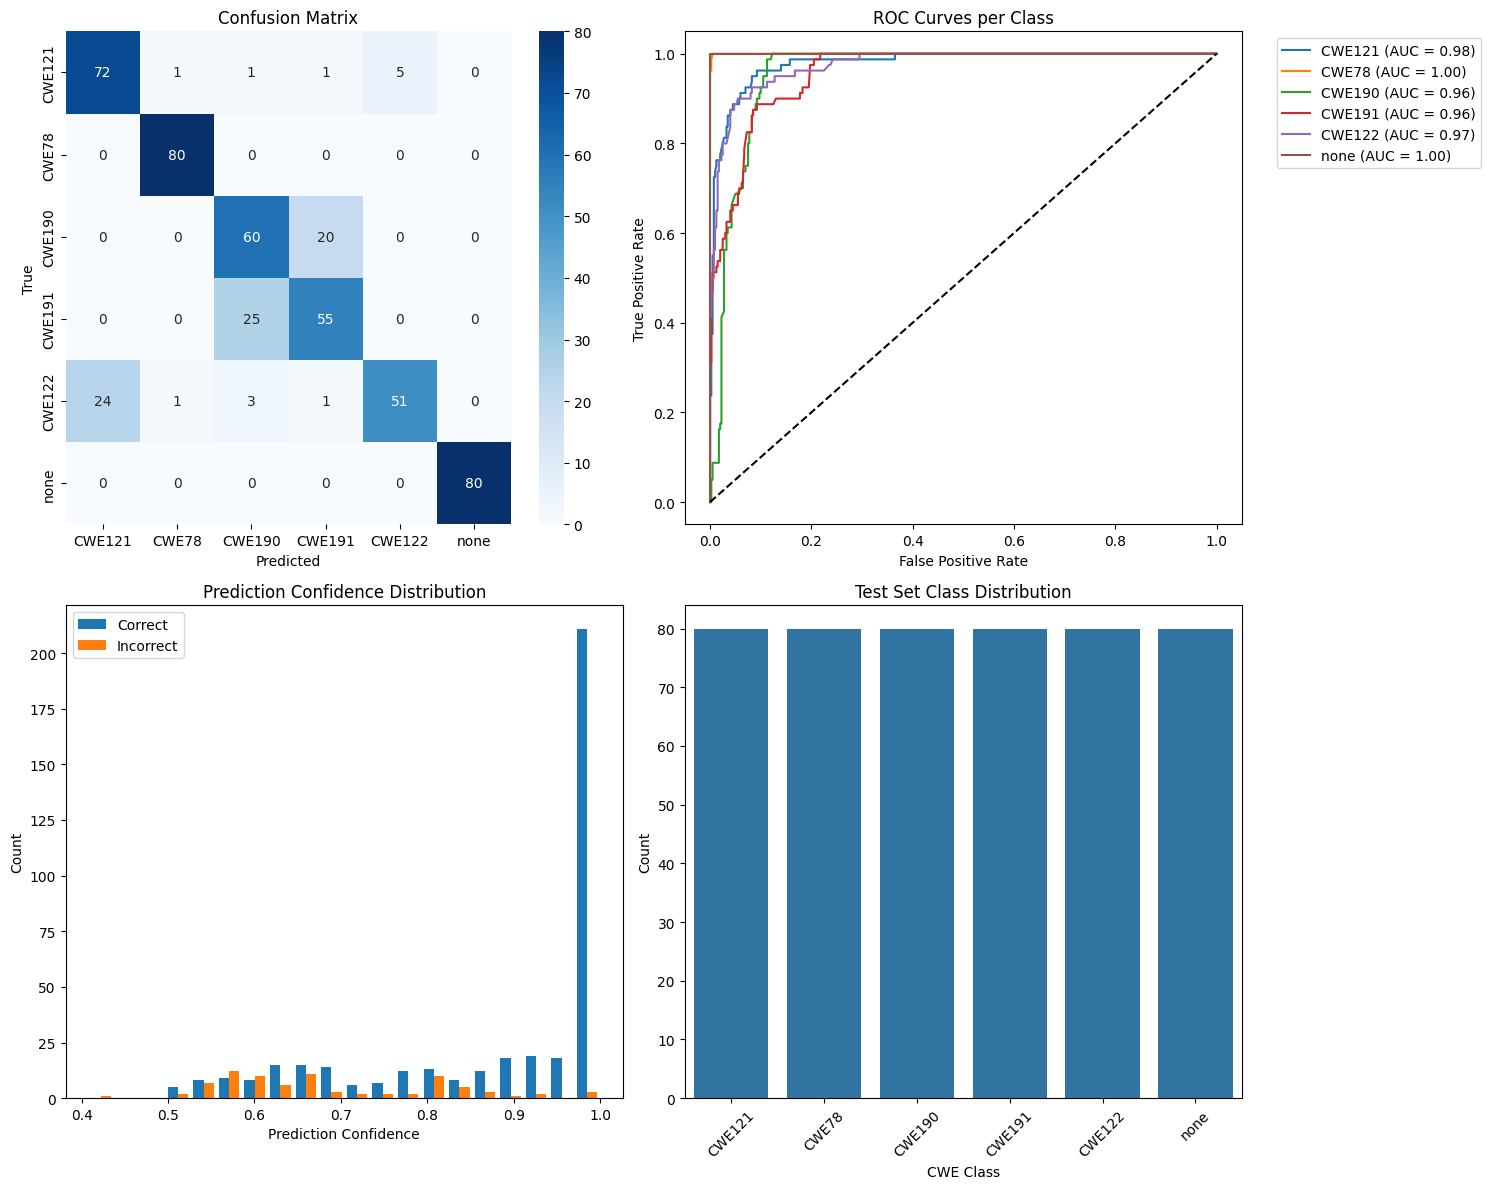

In [13]:
# Visualization imports
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Plot confusion matrix
plt.subplot(2, 2, 1)
sns.heatmap(
    confusion_matrix(all_labels, all_preds),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=dataset.cwe_classes,
    yticklabels=dataset.cwe_classes
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot ROC curves
plt.subplot(2, 2, 2)
for i in range(len(dataset.cwe_classes)):
    y_true = (all_labels == i).astype(int)
    y_score = all_probs[:, i]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{dataset.cwe_classes[i]} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot prediction confidence distribution
plt.subplot(2, 2, 3)
correct_probs = []
incorrect_probs = []
for i, (pred, true, probs) in enumerate(zip(all_preds, all_labels, all_probs)):
    max_prob = np.max(probs)
    if pred == true:
        correct_probs.append(max_prob)
    else:
        incorrect_probs.append(max_prob)

plt.hist([correct_probs, incorrect_probs], bins=20, label=['Correct', 'Incorrect'])
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Prediction Confidence Distribution')
plt.legend()

# Plot class distribution
plt.subplot(2, 2, 4)
sns.countplot(x=all_labels, order=range(len(dataset.cwe_classes)))
plt.xticks(range(len(dataset.cwe_classes)), dataset.cwe_classes, rotation=45)
plt.xlabel('CWE Class')
plt.ylabel('Count')
plt.title('Test Set Class Distribution')

plt.tight_layout()
plt.show()

In [14]:
def analyze_sample_predictions(model, test_dataset, test_samples, cwe_classes, n_samples=5):
    """Analyze individual sample predictions with attention visualization"""
    model.eval()

    # Get random indices
    indices = np.random.choice(len(test_dataset), n_samples, replace=False)

    for idx in indices:
        # Get sample
        sample = test_samples[idx]
        batch = test_dataset[idx]

        # Move to device
        inputs = {k: v.unsqueeze(0).to(device) for k, v in batch.items() if k != 'labels'}
        true_label = batch['labels'].item()

        # Get prediction
        with torch.no_grad():
            outputs, _ = model(**inputs)
            probs = torch.softmax(outputs, dim=1)[0]
            pred = outputs.argmax(dim=1)[0]

        # Print results
        print('\n' + '='*80)
        print(f'Sample Analysis:\n')
        print(f'True CWE: {cwe_classes[true_label]}')
        print(f'Predicted CWE: {cwe_classes[pred.item()]}')
        print('\nPrediction Probabilities:')
        for i, p in enumerate(probs):
            print(f'{cwe_classes[i]}: {p.item():.4f}')

        print('\nCode Sample Preview:')
        print(sample.code[:500] + '...' if len(sample.code) > 500 else sample.code)

# Analyze some sample predictions
print("Analyzing sample predictions...")
analyze_sample_predictions(model, test_dataset, test_samples, dataset.cwe_classes)

Analyzing sample predictions...

Sample Analysis:

True CWE: CWE78
Predicted CWE: CWE78

Prediction Probabilities:
CWE121: 0.0010
CWE78: 0.9985
CWE190: 0.0003
CWE191: 0.0001
CWE122: 0.0001
none: 0.0001

Code Sample Preview:
#include "std_testcase.h"
#include <wchar.h>
#ifdef _WIN32
#define COMMAND_INT_PATH "%WINDIR%\\system32\\cmd.exe"
#define COMMAND_INT "cmd.exe"
#define COMMAND_ARG1 "/c"
#define COMMAND_ARG2 "dir "
#define COMMAND_ARG3 data
#else 
#include <unistd.h>
#define COMMAND_INT_PATH "/bin/sh"
#define COMMAND_INT "sh"
#define COMMAND_ARG1 "-c"
#define COMMAND_ARG2 "ls "
#define COMMAND_ARG3 data
#endif
#include <process.h>
#ifndef OMITBAD
void CWE78_OS_Command_Injection__char_console_w32spawnl_32_bad()
{...

Sample Analysis:

True CWE: CWE121
Predicted CWE: CWE121

Prediction Probabilities:
CWE121: 0.9577
CWE78: 0.0001
CWE190: 0.0000
CWE191: 0.0000
CWE122: 0.0420
none: 0.0001

Code Sample Preview:
#include "std_testcase.h"
#ifndef OMITBAD
void var(int64_t * data)
{
    {
   

In [15]:
def predict_vulnerability(model, code: str, tokenizer, cwe_classes):
    """Helper function for making predictions on new code samples"""
    model.eval()

    # Preprocess code
    processed_code = CodeSample(code=code, label=0).preprocess().processed_code

    # Tokenize
    inputs = tokenizer(
        processed_code,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs, _ = model(**inputs)
        probs = torch.softmax(outputs, dim=1)[0]
        pred = outputs.argmax(dim=1)[0]

    # Format results
    results = {
        'predicted_cwe': cwe_classes[pred.item()],
        'confidence': probs[pred].item(),
        'all_probabilities': {
            cwe: prob.item()
            for cwe, prob in zip(cwe_classes, probs)
        }
    }

    return results

# Example usage
test_code = """
void vulnerable_function(char *input) {
    char buffer[64];
    strcpy(buffer, input);  // Potential buffer overflow
}
"""

print("Testing model inference...")
results = predict_vulnerability(model, test_code, tokenizer, dataset.cwe_classes)
print("\nPrediction Results:")
print(f"Predicted CWE: {results['predicted_cwe']}")
print(f"Confidence: {results['confidence']:.4f}")
print("\nAll class probabilities:")
for cwe, prob in results['all_probabilities'].items():
    print(f"{cwe}: {prob:.4f}")

Testing model inference...

Prediction Results:
Predicted CWE: none
Confidence: 0.9999

All class probabilities:
CWE121: 0.0000
CWE78: 0.0000
CWE190: 0.0000
CWE191: 0.0000
CWE122: 0.0000
none: 0.9999
